In [2]:
import torch
import cv2
import numpy
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets

In [4]:
# load cifar dataset
print(f"{torch.__version__ = }")
print(f"{torchvision.__version__ = }")


torch.__version__ = '2.3.0+cu121'
torchvision.__version__ = '0.18.0+cu121'


In [5]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

100%|██████████| 170498071/170498071 [00:55<00:00, 3049471.07it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


In [6]:
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified


In [49]:
from torch.utils.data import Dataset
import os
import numpy as np 
import pickle
from PIL import Image
from torchvision.transforms import Compose, ToTensor
class CIFAR10(Dataset):
    def __init__(self, root, train, transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        
        # get files
        train_split = [file for file in os.listdir(self.root) if "data_batch" in file]
        test_split = [file for file in os.listdir(self.root) if "test_batch" in file]
        
        split_to_use = train_split if self.train else test_split
        
        self.data = []
        self.labels = []
        
        for batch in split_to_use:
            batch_data = self.load(os.path.join(self.root, batch))
            self.data.append(batch_data["data"])
            self.labels.extend(batch_data["labels"])
        
        
        self.data = np.vstack(self.data)
        self.data = self.data.reshape(-1, 3, 32, 32)
        self.data = self.data.transpose(0, 2, 3, 1)
        self.load_info()
        
    def load(self, file_name):
        with open(file_name, "rb") as file:
            data = pickle.load(file, encoding="latin1")
        return data
    def load_info(self):
        file_path = os.path.join(self.root, "batches.meta")
        with open(file_path, "rb") as file:
            data = pickle.load(file, encoding="latin1")
            self.classes = data["label_names"]
            # get class to index and index to class
            self.class_to_index = {cls: i for i, cls in enumerate(self.classes)}
            self.index_to_class = {i: cls for cls, i in self.class_to_index.items()}
             
    def display(self, img_idx, label=True):
        img, label = self[img_idx]
        plt.figure(figsize=(3, 3))
        # change to W X H X C
        new_img = img.permute(1, 2, 0)
        plt.imshow(new_img)
        plt.grid(visible=False)
        plt.axis("off")
        if label:
            plt.title(f"Label = {self.index_to_class[label]}")
        plt.show()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        

In [50]:
transforms = Compose([
    ToTensor()
])

train_set = CIFAR10(root="./data/cifar-10-batches-py", 
        train=True, transform = transforms)
test_set = CIFAR10(root="./data/cifar-10-batches-py", 
        train=False, transform = transforms)

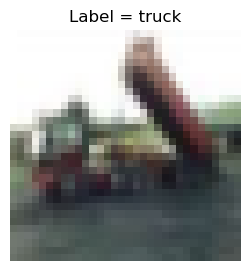

In [117]:
train_set.display(2, True)

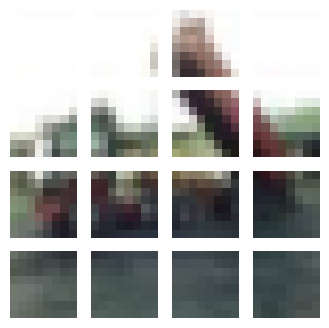

In [124]:
# split images into patches
import torch.nn.functional as F 

patch_size = 8
stride = 8

images, label = train_set[2]

# resize_transform = torchvision.transforms.Resize((72, 72))
# images = resize_transform(images)
# images = images.unsqueeze(0)
# print(f"{images.shape = }")
patches = images.unfold(1, patch_size, stride).unfold(2, patch_size, stride).contiguous()
image_size = 32
patches = patches.view(-1, (image_size//patch_size)**2, patch_size, patch_size)
patches = patches.permute(1, 0, 2, 3)

plt.figure(figsize=(4, 4))
# patches = patches.permute(0, 2, 1)
# patches = patches.view(images.size(0), -1, images.size(1), patch_size, patch_size)
n = int(np.sqrt(patches.shape[0]))
patches = patches.squeeze(0)
for i, patch in enumerate(patches):
    ax = plt.subplot(n, n, i+1)
    patch_img = patch.permute(1, 2, 0)
    plt.imshow(patch_img.numpy(), cmap="gray")
    plt.axis("off")